In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate

In [239]:
!pwd

/Users/atalianb/Documents/Doctorado/BosonStars/Shooting_LBS


### Para $\ell=0$ la condición inicial $\phi_{0}$ no cambia y es $\phi_{0} = 1$, por lo que los términos a ajustar serán $\epsilon$ y $m_{a}$

In [2]:
##Values
####
eps_ = 2.5e-4#
m_a_ = 1.0e-22#eV/c^2
#r_num = vecRp_data[-1]*eps*m_a/6.39e-27
####
##Integration values
###
x0_0 = 3.#first integration
x0_0v1 = 0.01# Start of integration. Use 0.01 for continuity in l=3 solution, for 0,1,2 0.0 it's ok
xf_0v1 = 10. # End of integration
step_0 = 0.5
##l=0
u1_0 = 0.63173215# 1st trial value of unknown init. cond.
u2_0 = 1.28125868# 2nd trial value of unknown init. cond.
u_0 = np.array([u1_0, u2_0])

In [3]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while x0 < x:
         # Count number of iterations using step size or
        h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [4]:
def shooting(func,u,x0,x,xf,step,k,h=0.01):
    def res(u):# Boundary condition residual
        X,Y = Integrate(func,x0,IC(u,k),x,h)
        y = Y[len(Y) - 1]#last value of Y
        r = np.zeros(len(u))
        r[0] = y[0]#y0(inf)=0
        r[1] = y[2]/x + y[3]#y_3(inf)/r + y_4(inf)=0
        return r
    x_list = []
    root_list = []
    while x<=xf:
        #print("x=",x)
        x_list.append(x)
        #print("u=",u)
        root = optimize.root(res,u)
        #print("root=",root)
        u = root.x
        #print("u=",u)
        root_temp = optimize.root(res,root.x)
        #print("root_temp=",root_temp)
        root_list.append(root_temp.x)
        X,Y = Integrate(func,x0,IC(root_temp.x,k),x,h)
        x = x+step
    return X,Y,root_temp,np.array(x_list),np.array(root_list)

In [5]:
def IC(u,k):#Initial conditions array, the first correspond to the initial condition in phi
    return np.array([k,0.0,u[0],0.0,u[1]])

In [6]:
def f0(x,y):
    l = 0.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F

In [7]:
def Mass_func(r,phi,l):
    Int = np.zeros(len(r))
    dr = np.diff(r)[0]
    phi_array = np.array(phi[:,0])
    for i in range(0,len(r)-1):
        Int[i+1] = dr*(phi_array[i+1]**2.*r[i+1]**(2.*l+2.)) + Int[i]
    return Int

In [8]:
def Vc2_cir(r,eps,M):
    units =8.95e10*eps**2.
    return (units*M)/r
####
##Units for r in kpc
###
def r_units(r,eps,m_a):
    return (6.39e-27*r)/(eps*m_a)

In [162]:
X0_f,Y0_f,root0_f,arr_x0,arr_list0=shooting(f0,u_0,x0_0v1,x0_0,xf_0v1,step_0,k=1.)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [163]:
M_r0 = Mass_func(X0_f,Y0_f,l=0.)
Vc2_r0 = Vc2_cir(X0_f,eps_,M_r0)
X0_units = r_units(X0_f,eps_,m_a_)

Text(0.5, 1.0, 'Circular speed')

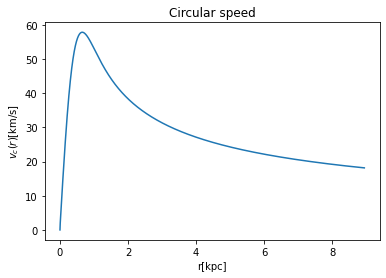

In [164]:
plt.plot(X0_units,np.sqrt(Vc2_r0))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title('Circular speed')

In [12]:
def r_wout_units(r_kpc,eps,m_a):
    return (eps*m_a*r_kpc/6.39e-27)

In [13]:
r_wout_units(r_kpc = X0_units[-1],eps=eps_,m_a = m_a_) + r_wout_units(r_kpc = X0_units[-1],eps=eps_,m_a = m_a_)*0.15

11.5

In [240]:
print(xf_0v1)

10.0


In [211]:
def Vc2_l0(r,m_a,eps,l=0.):
    r_num = r_wout_units(r_kpc = r,eps=eps_,m_a = m_a_)
    #print(r_num[-1])
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(f0,u_0,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    Xl0 = r_num
    M_r0 = Mass_func(Xl0,Y0,l=0.)
    Vc2_r0 = Vc2_cir(Xl0,eps,M_r0)
    X0_units = r_units(Xl0,eps,m_a)
    return np.sqrt(Vc2_r0)

In [15]:
Vc2_l0_test = Vc2_l0(r=X0_units,m_a=m_a_,eps=eps_,l=0.)

Text(0.5, 1.0, 'Circular speed')

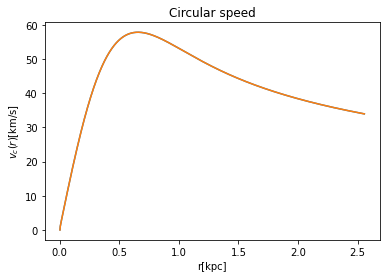

In [16]:
plt.plot(X0_units,Vc2_l0_test)
plt.plot(X0_units,np.sqrt(Vc2_r0))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title('Circular speed')

Text(0.5, 1.0, 'Mass function')

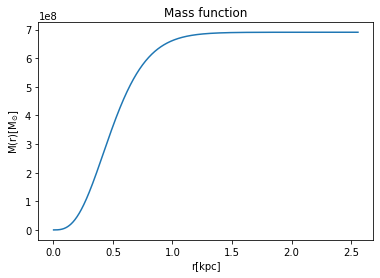

In [45]:
plt.plot(X0_units,M_r0*eps_*1.34e-10/m_a_)
plt.ylabel(r'M(r)[M$_{\odot}]$')
plt.xlabel("r[kpc]")
plt.title('Mass function')

In [272]:
M_r0[-1]

2.063524253223583

In [273]:
M_r0[-1]*eps_*1.34e-10/m_a_

691280624.8299004

In [274]:
_/X0_units[-1]

77272593.87769957

In [186]:
phi_units = eps_**4./(4.*np.pi*(1.56e-201))

In [136]:
m_a_**2.*phi_units**2.*((6.39e-27)/(eps_*m_a_))**3.

26619390.529580962

In [131]:
eps_*1.34e-10/m_a_ 335000000

335000000.0

In [193]:
def Mass_func_units(r,phi,l):
    Int = np.zeros(len(r))
    dr = np.diff(r)[0]
    phi_array = np.array(phi[:,0])
    for i in range(0,len(r)-1):
        Int[i+1] = m_a_**2.*6.39e-27*dr*(phi_units*phi_array[i+1]**2.*r[i+1]**(2.*l+2.))/(m_a_*eps_)+ Int[i]
    return Int

In [194]:
Mr_test = Mass_func_units(X0_units,Y0_f,l=0.)

Text(0.5, 1.0, 'Mass function')

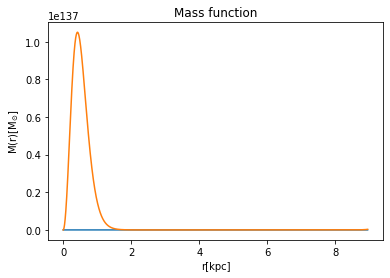

In [195]:
plt.plot(X0_units,M_r0*eps_*1.34e-10/m_a_)
plt.plot(X0_units,Mr_test)
plt.ylabel(r'M(r)[M$_{\odot}]$')
plt.xlabel("r[kpc]")
plt.title('Mass function')

In [140]:
Mr_test[-1],M_r0[-1]*eps_*1.34e-10/m_a_

(0.03443703580386135, 690856774.6596841)

In [141]:
0.03443703580386135/690856774.6596841

4.9846852585074566e-11

# con r[kpc] de los datos

In [18]:
path = "/Users/atalianb/Documents/data_LBSG/LSBG/LSBG/"
data = np.loadtxt(path+"F563-V2_rotmod.dat")

In [19]:
vecRp_data = np.array([row[0] for row in data])# galactocentric distance [kpc]
vecvRp_data = np.array([row[1] for row in data])# rotation velocity [km/s]
vecerrvRp_data = np.array([row[2] for row in data])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

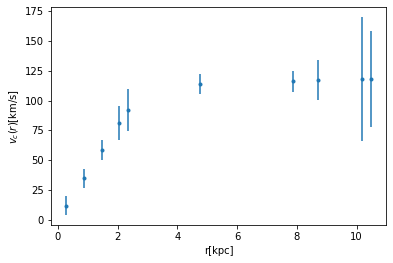

In [20]:
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# un parámetro

$\epsilon$

### Para datos con aproximadamente una apmplitud de 110km/s tendremos un $\epsilon$ de 
$$\epsilon =\sqrt{\frac{110^{2}}{8.95\times 10^{10}}}$$

In [25]:
eps_data = np.sqrt(110**2./8.95e10)
print(eps_data)

0.0003676894487556816


In [241]:
np.sqrt(120**2./8.95e10)

0.0004011157622789254

In [256]:
def Vc2_l0_xy(m_a,eps,l=0.):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(f0,u_0,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    M_r0 = Mass_func(X0,Y0,l=0.)
    Vc2_r0 = Vc2_cir(X0,eps,M_r0)
    X0_units = r_units(X0,eps,m_a)
    return np.sqrt(Vc2_r0),X0_units

In [259]:
print(m_a_)

1e-22


In [270]:
Vc2_l0_data = Vc2_l0_xy(m_a=1.0e-23,eps=5.0e-4,l=0.)

Text(0.5, 0, 'r[kpc]')

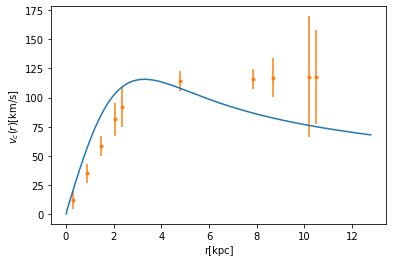

In [271]:
plt.plot(Vc2_l0_data[1],Vc2_l0_data[0])
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Interpolación

In [199]:
from scipy import interpolate

In [260]:
f = interpolate.interp1d(Vc2_l0_data[1],Vc2_l0_data[0],fill_value='extrapolate')
vecRp_data_new = np.arange(0.,vecRp_data[-1],0.1)
vecvRp_data_new = f(vecRp_data_new)

Text(0.5, 0, 'r[kpc]')

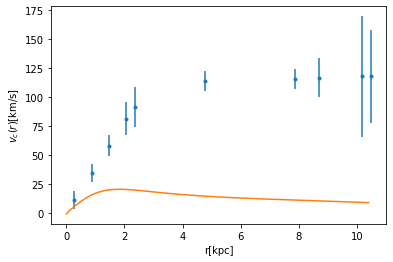

In [261]:
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.plot(vecRp_data_new,vecvRp_data_new)
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [149]:
vecRp_data[-1]*m_a_*eps_data/6.36e-27

60.53000830930796

# $\chi^{2}$

In [212]:
def Xi2_eps(parameter):
    eps = np.exp(parameter)
    model = Vc2_l0(vecRp_data,m_a_,eps,l=0.)
    xi = np.sum((vecvRp_data-model)**2./(vecerrvRp_data)**2.)
    return xi

In [213]:
x0_eps = np.array(np.log(1.0e-4))
LS_eps = optimize.minimize(Xi2_eps,x0_eps,method='L-BFGS-B',bounds=((np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_eps)

      fun: 22.753184131530862
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.10542677e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 32
      nit: 8
     njev: 16
   status: 0
  success: True
        x: array([-10.1737723])


In [214]:
Xi2_eps(np.asscalar(LS_eps.x))

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


22.753184131530862

In [35]:
print(np.exp(LS_eps.x))

[3.81581077e-05]


In [215]:
print(np.exp(LS_eps.x))

[3.81581077e-05]


# Extrapolación

In [233]:
Vc_chi = Vc2_l0_xy(r=vecRp_data,m_a=m_a_,eps=np.asscalar(LS_eps.x),l=0.)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


In [234]:
f_new = interpolate.interp1d(Vc_chi[1],Vc_chi[0],fill_value='extrapolate')
R_data_new = np.arange(0.,vecRp_data[-1],0.1)
vR_data_new = f_new(R_data_new)

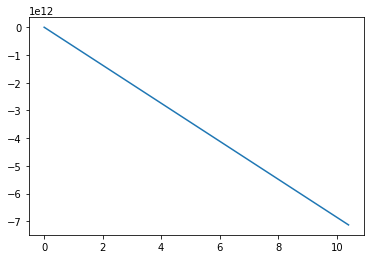

In [236]:
plt.plot(R_data_new,vR_data_new)

Text(0.5, 0, 'r[kpc]')

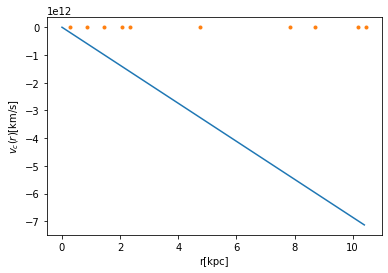

In [237]:
plt.plot(R_data_new,vR_data_new)
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

Text(0.5, 0, 'r[kpc]')

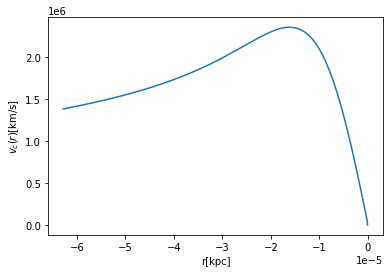

In [238]:
plt.plot(Vc_chi[1],Vc_chi[0])
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [227]:
Vc2_l0_chi = Vc2_l0(r=vecRp_data,m_a=m_a_,eps=np.asscalar(LS_eps.x),l=0.)

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


In [230]:
len(Vc2_l0_chi)

10

Text(0.5, 0, 'r[kpc]')

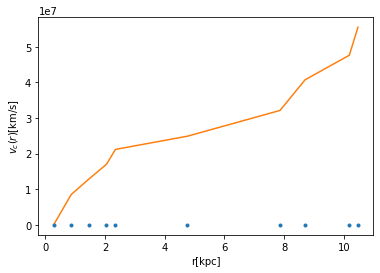

In [232]:
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.plot(vecRp_data,Vc2_l0_chi)
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

Text(0.5, 1.0, '$\\epsilon$')

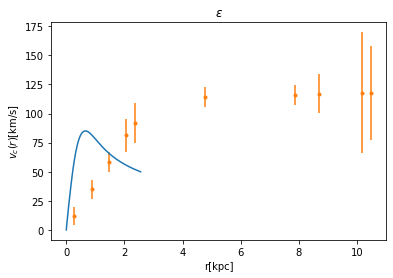

In [43]:
plt.plot(X0_units,Vc2_l0(X0_units,m_a=m_a_,eps=eps_data,l=0.))
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$\epsilon$')

In [44]:
(4.302e-6)*(6.58e-16)**2.*(3.24e-17)**2.

1.95529465772928e-69

# Dos parámetros

$m_{a}$ y $\epsilon$

In [37]:
def Vc_l0_m_a_eps(r,params):
    m_a,eps = params
    return Vc2_l0(r,m_a,eps,phi0_0=1.,l=0.)

In [38]:
def Xi2_m_a_eps(params):
    m_a,eps = params
    par = np.exp(m_a),eps
    model = Vc_l0_m_a_eps(vecRp_data,par)
    xi  = np.sum((vecvRp_data-model)**2./(vecerrvRp_data)**2.)
    return xi

In [39]:
x0_m_a_eps = np.array([np.log(1.0e-24),1.0e-5])
LS_m_a_eps = optimize.minimize(Xi2_m_a_eps,x0_m_a_eps,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(1.0e-5,1.),))
print(LS_m_a_eps)

      fun: 22.75318422055957
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.02916352])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 2
     njev: 11
   status: 0
  success: True
        x: array([-5.52620422e+01,  3.81576082e-04])


In [40]:
print(np.exp(LS_m_a_eps.x[0]))

1.000000000000002e-24


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '$m_{a},\\epsilon$')

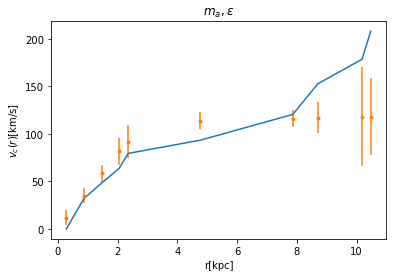

In [41]:
plt.plot(vecRp_data,Vc2_l0(vecRp_data,m_a=np.asscalar(np.exp(LS_m_a_eps.x[0])),eps=np.asscalar(LS_m_a_eps.x[1]),phi0_0=1.0,l=0.))
plt.errorbar(vecRp_data,vecvRp_data,yerr=vecerrvRp_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$m_{a},\epsilon$')